In [123]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [138]:
#!mkdir -p content
#!tar -xvf data_heisenberg_L_10_J_1_runNo_1.tar.gz -C ./content

In [125]:
# Class: For data loading and preprocessing

class HeisenbergDataset:
    """
    Class for loading, storing, and preparing the Heisenberg spin configuration data.

    Each data sample corresponds to a spin configuration generated under a certain temperature
    (identified by temp_id), and stored as a text file. The dataset consists of multiple configurations
    for each temperature.
    """
    def __init__(self, data_path, n_id=30, n_config=100):
        """
        Initialize the dataset handler.
        
        Args:
        - data_path: path to the root directory where all temp_id folders are stored.
        - n_id: number of temperature identifiers (temp_id values).
        - n_config: number of configurations per temperature ID.
        """
        self.data_path = data_path
        self.n_id = n_id
        self.n_config = n_config
        self.data = None
        
    def CreateDataset(self, id, config):
        """
        Loads a single spin configuration as a numpy array.

        Args:
        - id: temperature ID (temp_id)
        - config: configuration index for this temp_id

        Returns:
        - A numpy array of shape (1000, 3), representing the spin configuration.
        """
        # Construct file path to the specific configuration
        file_path = os.path.join(self.data_path,f'temp_id_{id}',f'temp_id_{id}_config_{config}.txt')
        df = pd.read_csv(file_path, header=None)  
        
        # Preallocate array to hold float vectors from the file  
        str_list = np.zeros((df.shape[0],3))
        
        # Convert space-separated string into floats for each line
        for i in range(len(str_list)):
            str_list[i] = np.array(df.iloc[i].str.split()[0], dtype='float')
        
        return str_list
    
    def LoadAllData(self):
        """
        Loads all spin configurations into memory.

        Returns:
        - A numpy array of shape (n_id * n_config, 1000, 3)
        """
        # Preallocate full dataset array
        data = np.ones((self.n_config * self.n_id,1000,3))
        i=0
        
        # Loop through all temp_ids and configurations
        for id in range(self.n_id):
            for config in range(self.n_config):
                data[i] = self.CreateDataset(id, config)
                i += 1
                
        self.data = data # store it in class variable
        return data
    
    def save(self, filename):
        """
        Saves the loaded data to a `.npy` file.

        Args:
        - filename: the path to save the file
        """
        if self.data is not None:
            np.save(filename, self.data)
        else:
            raise ValueError("Data not loaded")
        
    def load(self, filename):
        """
        Loads data from a `.npy` file.

        Args:
        - filename: the path to the saved `.npy` file

        Returns:
        - Loaded numpy array
        """
        self.data = np.load(filename)
        return self.data
    
    def PrepareLabels(self, lower_id=10, upper_id=20):
        """
        Creates labels for supervised and semi-supervised learning.

        Args:
        - lower_id: lower boundary for unlabeled temperature ID range
        - upper_id: upper boundary for unlabeled temperature ID range

        Returns:
        - X_full: all data (including unlabeled)
        - X_labeled: only data with labels (excluding the middle range)
        - y_full: label vector with np.nan in place of unlabeled data
        - y_labeled: only the labeled part of the label vector
        """
        # Create labels:
        # - 0 for low temperatures (ordered phase)
        # - 1 for high temperatures (disordered phase)
        # - NaN for the middle temperatures (unknown phase)
        y1 = np.zeros(self.n_config * lower_id)                         # labels for low temp_ids
        y2 = np.ones(self.n_config * (upper_id - lower_id)) * np.nan    # unlabeled mid range
        y3 = np.ones(self.n_config * (self.n_id - upper_id))            # labels for high temp_ids
        y_full = np.concatenate((y1, y2, y3))       # includes both labeled and unlabeled
        y_labeled = np.concatenate((y1, y3))        # only the labeled parts

        # Prepare the corresponding X data
        X1 = self.data[:(self.n_config * lower_id)]
        X2 = self.data[self.n_config * upper_id:]
        X_labeled = np.concatenate([X1, X2])

        return self.data, X_labeled, y_full, y_labeled

In [126]:
class HeisenbergTrainer:
    def __init__(self, X_labeled, y_labeled):
        """
        Split the labeled dataset into train, validation, and test sets.
        """
        self.X_train_full, self.X_test, self.y_train_full, self.y_test = train_test_split(X_labeled, y_labeled)
        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(self.X_train_full, self.y_train_full)
        
    def BuildModel(self):
        """
        Define a simple feedforward neural network model.

        Returns:
            keras.Model: Compiled binary classification model.
        """
        input = keras.layers.Input(shape=self.X_train.shape[1:])
        flat =keras.layers.Flatten()(input)
        hidden1 = keras.layers.Dense(30, activation='relu', kernel_initializer='he_normal')(flat)
        hidden2 = keras.layers.Dense(30, activation='relu', kernel_initializer='he_normal')(hidden1)
        output = keras.layers.Dense(1, activation='sigmoid')(hidden2)
        
        self.model = keras.models.Model(inputs=input,outputs=output)
        
        self.model.compile(optimizer='sgd', loss=keras.losses.binary_crossentropy, metrics=[keras.metrics.BinaryAccuracy()])
        
        return self.model
    
    def train(self, epochs=200, checkpoint_path="./content/my_logger.keras"):
        """
        Train the model with early stopping and model checkpointing.

        Args:
            epochs (int): Number of epochs.
            checkpoint_path (str): Filepath to save the best model.
        """
        checkpoint_cb = keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
        self.history = self.model.fit(
            self.X_train, self.y_train,
            epochs=epochs,
            validation_data=(self.X_valid, self.y_valid),
            callbacks=[checkpoint_cb, early_stopping_cb])
        
    def evaluate(self):
        """
        Evaluate the trained model on the test set.
        """
        self.model.evaluate(self.X_test, self.y_test)
        
    def plot_history(self):
        """
        Plot training and validation loss over epochs.
        """
        pd.DataFrame(self.history.history).plot()
        plt.show()
        
    def predict(self, X):
        """
        Predict probabilities on new data.

        Args:
            X (np.ndarray): Input samples.

        Returns:
            np.ndarray: Prediction probabilities.
        """
        return self.model.predict(X)

    def PredictAndPlot(self, X_full, temperatures):
        """
        Predict on the entire dataset and visualize predictions per temperature group.

        Args:
            X_full (np.ndarray): All samples.
            temperatures (np.ndarray): Array of temperature values for labeling x-axis.
        """
        predictions = self.model.predict(X_full)
        mpl.rcParams['figure.figsize'] = (15, 7)
        plt.plot(predictions, '.')
        plt.xticks(np.arange(len(temperatures)) * 100, np.round(temperatures, 2), rotation=20)
        plt.xlabel('Temperature')
        plt.show()

In [127]:
# Instantiating the HeisenbergDataset class
dataset = HeisenbergDataset('./content/data_heisenberg_L_10_J_1_runNo_1')

In [128]:
# Load data and save for future use
dataset.LoadAllData()
dataset.save('./content/heisenberg_data.npy')

In [129]:
# Load preprocessed data and split datasets

dataset.load('./content/heisenberg_data.npy')
X_full, X_labeled, y_full, y_labeled = dataset.PrepareLabels(lower_id=10, upper_id=20)

In [130]:
#Instantiating the HeisenbergTrainer class
trainer = HeisenbergTrainer(X_labeled, y_labeled)

In [131]:
model = trainer.BuildModel()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1000, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 30)             │        90,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,991 (355.43 KB)

 Trainable params: 90,991 (355.43 KB)

 Non-trainable params: 0 (0.00 B)

In [132]:
# Training the model
trainer.train()

Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6056 - loss: 0.6415 - val_binary_accuracy: 0.8160 - val_loss: 0.4175
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.3546 - val_binary_accuracy: 0.8773 - val_loss: 0.3255
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9697 - loss: 0.2460 - val_binary_accuracy: 0.9147 - val_loss: 0.2700
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9897 - loss: 0.1909 - val_binary_accuracy: 0.9333 - val_loss: 0.2321
Epoch 5/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9978 - loss: 0.1478 - val_binary_accuracy: 0.9467 - val_loss: 0.2047
Epoch 6/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9984 - loss: 0.1162 - val_binary_accuracy: 0.9573 - val_loss: 0.1826
Epoch 7/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9977 - loss: 0.0941 - val_binary_accuracy: 0.9627 - val_loss: 0.1662
Epoch 8/200
3

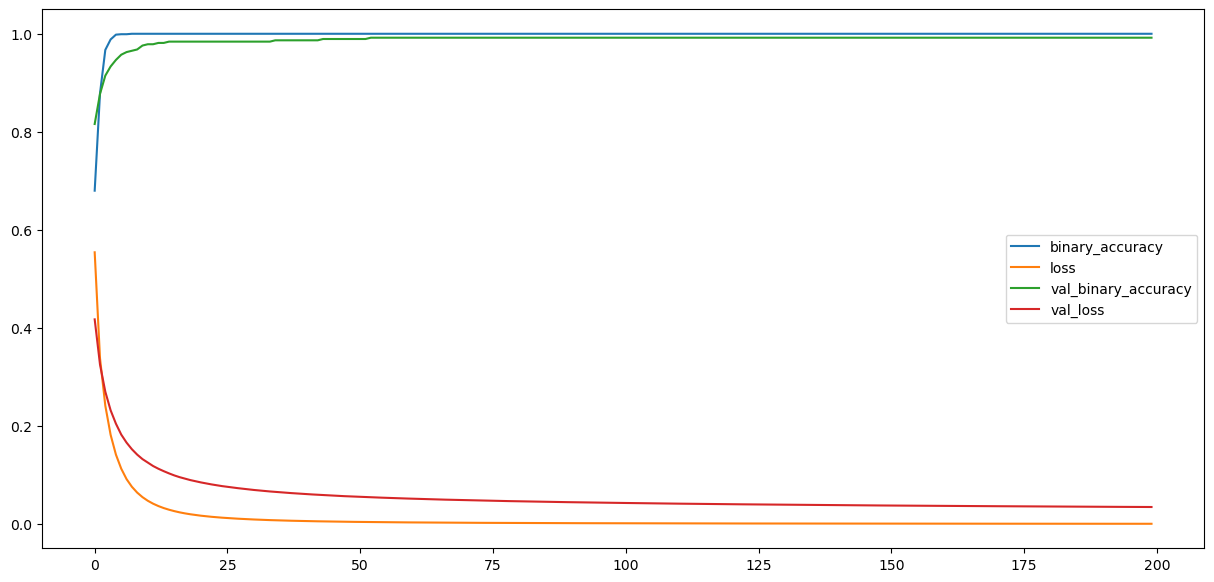

In [133]:
# Plot accuracy and the loss
trainer.plot_history()

In [134]:
trainer.evaluate()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - binary_accuracy: 0.9820 - loss: 0.0402


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step


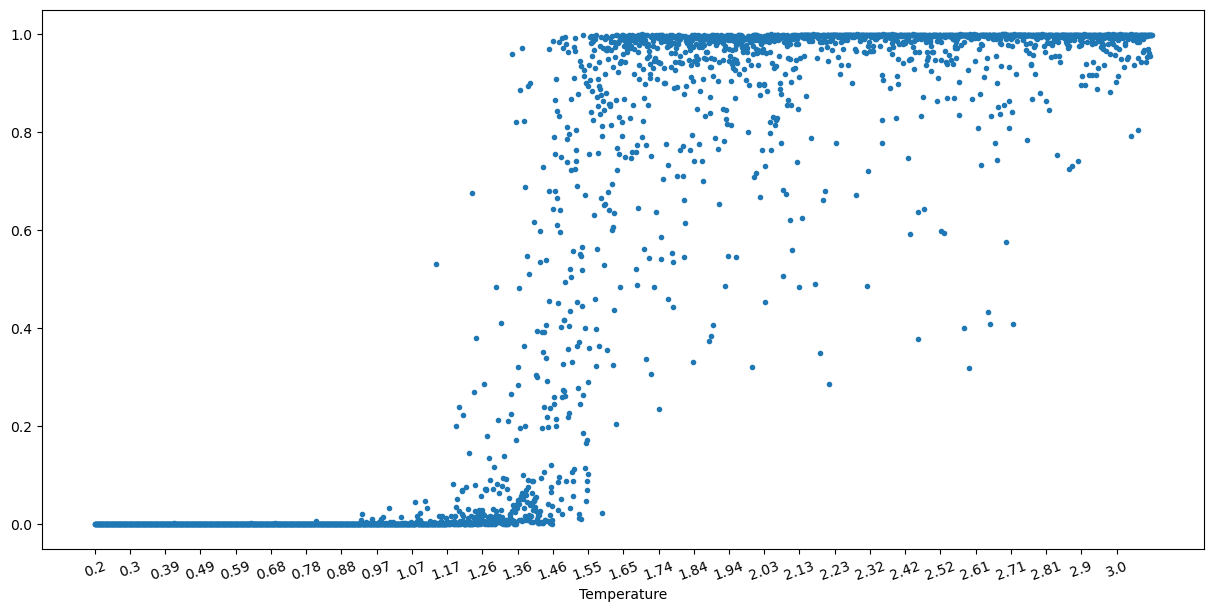

In [135]:
# Temperature values
Temperatures = np.array([0.2                 
,0.296551724138      
,0.393103448276      
,0.489655172414      
,0.586206896552      
,0.68275862069       
,0.779310344828      
,0.875862068966      
,0.972413793103      
,1.06896551724       
,1.16551724138       
,1.26206896552       
,1.35862068966       
,1.45517241379       
,1.55172413793       
,1.64827586207       
,1.74482758621       
,1.84137931034       
,1.93793103448       
,2.03448275862       
,2.13103448276       
,2.2275862069        
,2.32413793103       
,2.42068965517       
,2.51724137931       
,2.61379310345       
,2.71034482759       
,2.80689655172       
,2.90344827586       
,3 ])

# Plot prediction against temperature
trainer.PredictAndPlot(X_full, Temperatures)

In [136]:

predictions = trainer.predict(X_full)
bins = np.split(predictions, len(Temperatures))
avg_values = np.zeros_like(Temperatures)
for i in range(len(Temperatures)):
    avg_values[i] = bins[i].mean()

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


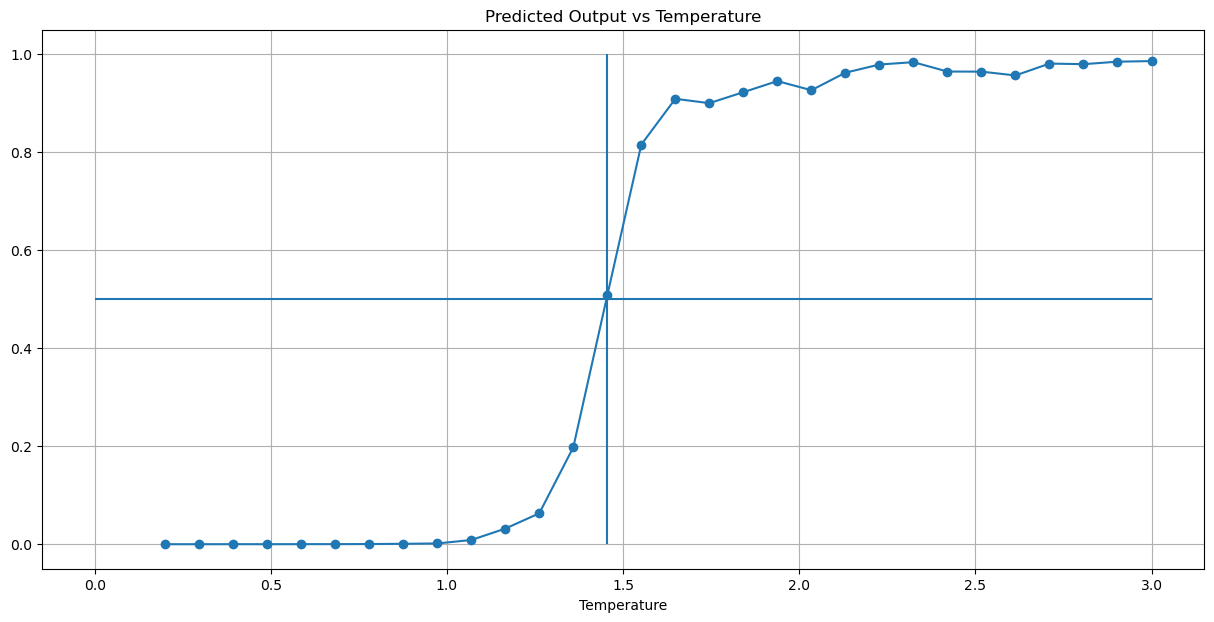

In [137]:
plt.plot(Temperatures, avg_values, marker='o')
plt.xlabel("Temperature")
plt.title("Predicted Output vs Temperature")
plt.xlabel('Temperature')
plt.hlines(0.5, 0, 3)
plt.vlines(1.454, 0, 1)
plt.grid(True)
plt.show()